# CVRP HW2 - part 1
In this part, you will explore AutoEncoder (AE) and Variational Auto-Encoder (VAE) on MNIST dataset.
To have faster training efficency, GPU acceleration is recommended. However, don't worry if you reach your GPU usage limit on Colab. This part can still be completed within a reasonable timeframe using a standard CPU.

Some notes:
- This part takes 50 points in total
- We will fix the size of latent code vector to be 2 !
- If you made any modifications on the cells with "DO NOT MODIFY" label, please be sure to write a detailed README, otherwise, TA will have a hard time grading your code...
- If you find it's hard to put all the things into a single notebook, you can have additional files. Make sure you have a README as well.
- Please zip all the notebooks or files you have to a compressed zip file before submission.

In [ ]:
# NOTE: DO NOT MODIFY
# Import neccessary packages
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pdb

# Decide which driver to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")

Device used : cuda


### MNIST dataset loader
Please do not modify this cell

In [ ]:
# NOTE: DO NOT MODIFY
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
							train = True,
							download = True,
							transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
										batch_size = batch_size,
										shuffle = True)


### Visualization functions
1. `plot_latent_images` will sample a vector with size 2 (same as $z$), feed into the decoder and plot out the decoded image
2. `plot_z` plots the distribution of $z$. Since $z$ has size 2, we can map it to a 2D plot and see the ddistribution of each class
3. `eval` visualizes the difference between the original images and reconstruncted images

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def plot_z(dataloader, model):
    batch_progress = dataloader
    latent_z = []
    all_labels = []
    for iter, (images, labels) in enumerate(batch_progress):
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1).to(device)
        output = model(images)
        encoded = output["z"]
        #print(encoded)
        latent_z.extend(list(encoded.detach().cpu()))
        all_labels.extend(list(labels.detach().cpu()))

    latent_z = np.array(latent_z)
    all_labels = np.array(all_labels)
    # plot 2D
    plt.figure(figsize=(10, 10))
    for label in range(10):
        # Filter points with the current label
        label_points = latent_z[all_labels == label]
        plt.scatter(label_points[:, 0], label_points[:, 1], label=f"Label {label}")

    plt.title("2D Plot of latent variable")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


### Training function
If you need to modify it, please make sure you have a README.

In [ ]:
def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        for iter, (images, labels) in enumerate(dataloader):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

    return losses


## **AutoEncoder (AE)**
We will start by implementing a simple auto-encoder (AE) and training it on the MNIST dataset.


Tasks:
1. [8 pts] Finish the implementation of `self.encoder` and `self.decoder` in `AE()` model
2. [2 pts] Complete the loss function
3. Train the AE model on the MNIST dataset (manual tuning of parameters such as epochs, hidden dims, and lr may be necessary). Use the provided evaluation code to visualize the reconstruction results and the generated images (in 2D grid) for the last epoch

In [ ]:

class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim=2):
        super().__init__()

        assert latent_dim == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
         ### Your code here ###
        # Build the encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))  # Map to latent space
        self.encoder = nn.Sequential(*encoder_layers)

        # Build the decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))  # Map back to input space
        self.decoder = nn.Sequential(*decoder_layers)



    def decode(self, z):
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        """
        Args:
            x : input data

        Return:
            imgs: decoded image from z
            z   : latent vector
        """
         ### Your code here ###
        encoded = self.encode(x)  # Get latent representation my code
        decoded = self.decode(encoded)  # Decode back to original space my code
        return {"imgs": decoded,
                "z": encoded}


### Loss Functions
Complete the function `loss_AE` with MSE loss

In [ ]:
mse = torch.nn.MSELoss()

def loss_AE(model, x):
    """
    Compute the reconstruction loss for the autoencoder.

    Args:
        model : The autoencoder model.
        x     : The input data.

    Returns:
        loss  : The MSE reconstruction loss.
    """
    # Forward pass through the model
    output = model(x)

    # Extract the reconstructed images
    reconstructed = output["imgs"]

    # Compute MSE loss between input and reconstructed images
    loss = mse(reconstructed, x)

    return loss


In [ ]:
import torch
import torch.nn as nn


### Optimizers and Training


In [ ]:
epochs = 50
hidden_dims = [128, 64, 36]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

ae = AE(input_dim, hidden_dims).to(device)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0231
Epoch [2/50], Average Loss: 0.0198
Epoch [3/50], Average Loss: 0.0185
Epoch [4/50], Average Loss: 0.0173
Epoch [5/50], Average Loss: 0.0167
Epoch [6/50], Average Loss: 0.0163
Epoch [7/50], Average Loss: 0.0160
Epoch [8/50], Average Loss: 0.0158
Epoch [9/50], Average Loss: 0.0156
Epoch [10/50], Average Loss: 0.0154
Epoch [11/50], Average Loss: 0.0154
Epoch [12/50], Average Loss: 0.0152
Epoch [13/50], Average Loss: 0.0151
Epoch [14/50], Average Loss: 0.0150
Epoch [15/50], Average Loss: 0.0149
Epoch [16/50], Average Loss: 0.0148
Epoch [17/50], Average Loss: 0.0148
Epoch [18/50], Average Loss: 0.0147
Epoch [19/50], Average Loss: 0.0147
Epoch [20/50], Average Loss: 0.0146
Epoch [21/50], Average Loss: 0.0145
Epoch [22/50], Average Loss: 0.0145
Epoch [23/50], Average Loss: 0.0144
Epoch [24/50], Average Loss: 0.0144
Epoch [25/50], Average Loss: 0.0143
Epoch [26/50], Average Loss: 0.0143
Epoch [27/50], Average Loss: 0.0143
Epoch [28/50], Average Loss: 0.0143
E

### Evaluation


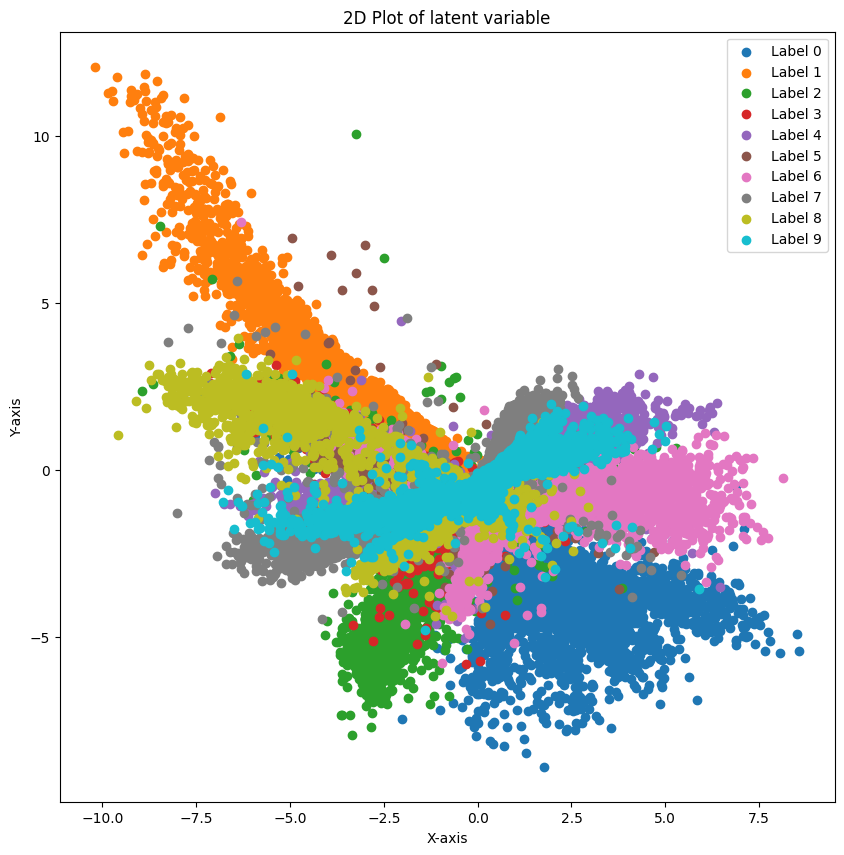

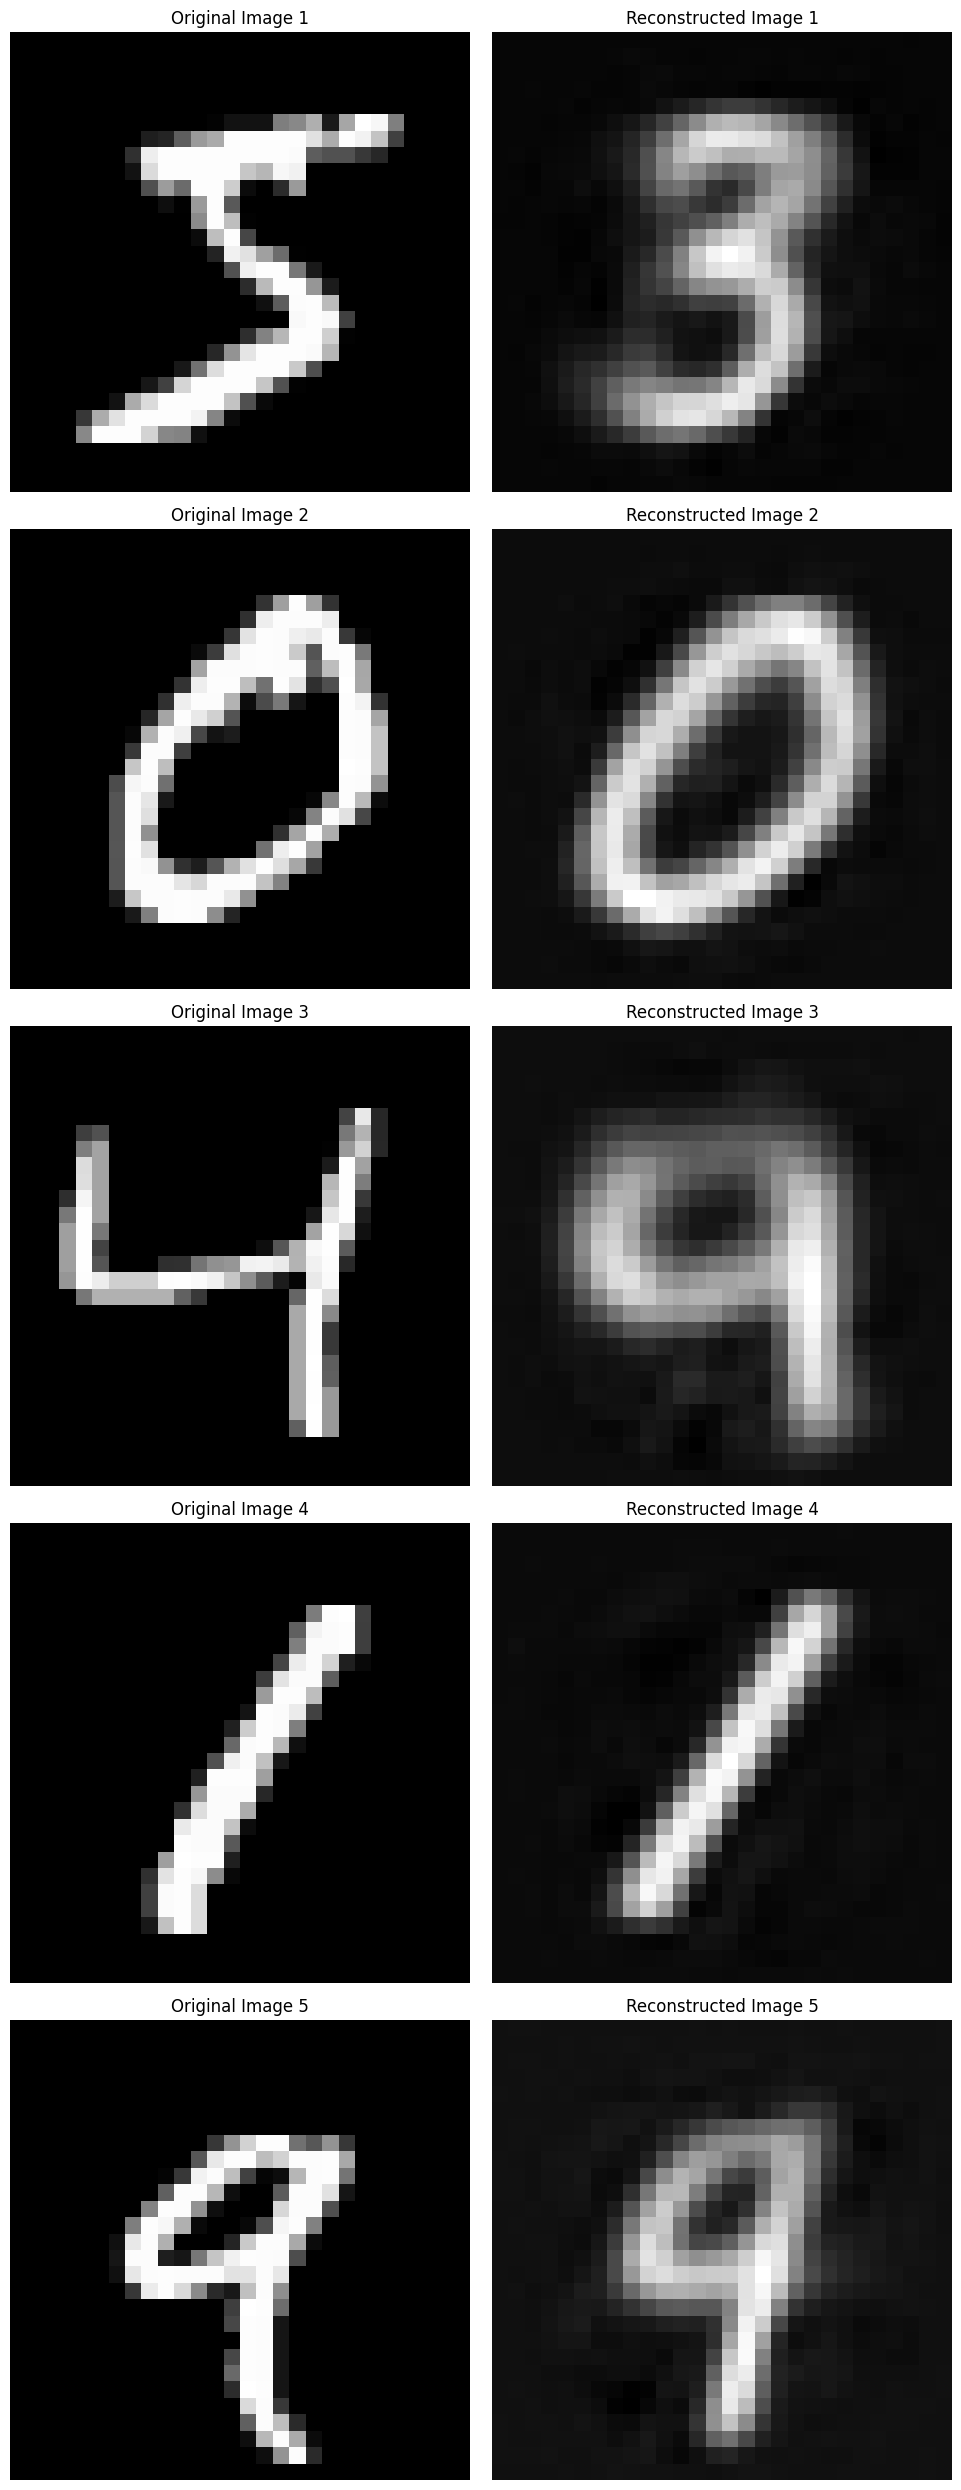

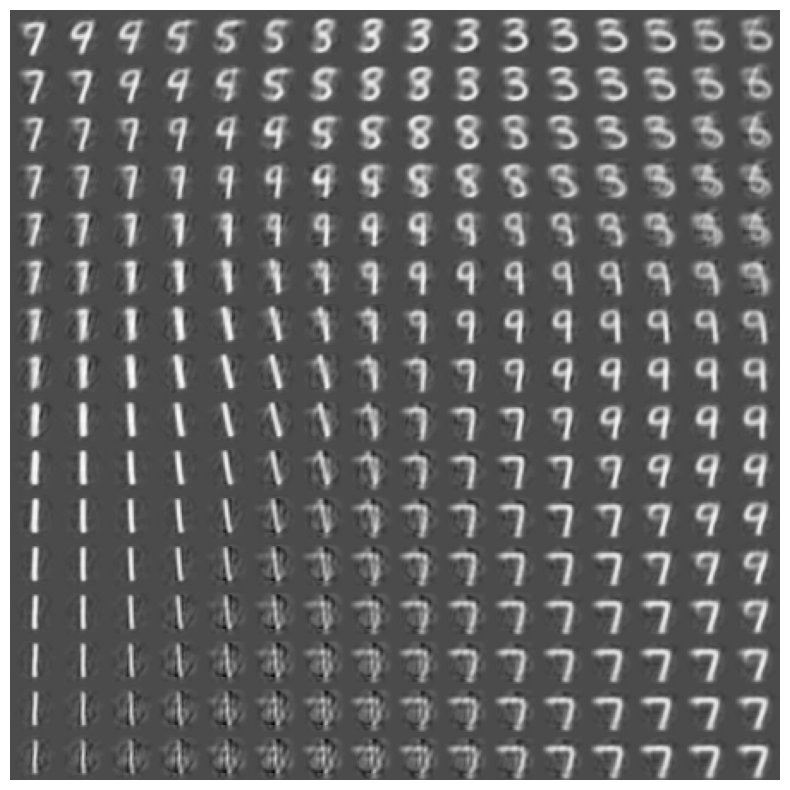

In [ ]:
plot_z(MNIST_loader, ae)
eval(ae)
plot_latent_images(ae, n=16)


## **Variational  AutoEncoder (VAE)**
Tasks:

1. [10 pts] Finish the implementation of `self.encoder` and `self.decoder` in `VAE()` model
2. [5 pts] Implement the reparameterization trick in the `reparameterize()` function
2. [5 pts] Complete the loss function
3. Train the VAE model on the MNIST dataset (manual tuning of parameters such as epochs, hidden dims, and lr may be necessary). Use the provided evaluation code to visualize the reconstruction results and the generated images (in 2D grid) for the last epoch


In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim=2):
        super().__init__()

        assert latent_dim == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        self.latent_dim = latent_dim

        # **Encoder**
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # **Latent Space**
        self.fc_mean = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # **Decoder**
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim

        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))  # Output layer
        decoder_layers.append(nn.Sigmoid())  # Normalize output to [0,1]
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """Encodes input x into latent mean and log variance."""
        x = x.view(x.size(0), -1)  # 🔹 Flatten input to (batch_size, input_dim)
        x = self.encoder(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """Reparameterization trick: sample from N(mean, var) using standard normal samples."""
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random normal noise
        return mean + eps * std  # Reparameterized sample

    def decode(self, z):
        """Decodes latent vector z back to input space."""
        return self.decoder(z)

    def forward(self, x):
        """Forward pass through the VAE."""
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decode(z)
        return {"imgs": decoded, "z": z, "mean": mean, "logvar": logvar}


### Loss Functions
Complete the function `loss_VAE()`

VAE loss = reconstrunction loss (similar to AE) + **coeff** * regularization loss (KL Divergence)


In [ ]:
mse = torch.nn.MSELoss()

def loss_VAE(model, x, coeff=1e-4):
    """
    Compute the VAE loss, which includes reconstruction loss and KL divergence.
    """
    output = model(x)

    # Extract components
    reconstructed = output["imgs"]
    mean = output["mean"]
    logvar = output["logvar"]

    # Reconstruction loss
    reconstruction_loss = mse(reconstructed, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)

    # Combined loss
    loss = reconstruction_loss + coeff * kl_loss

    return loss  # Return only the total loss


### Optimizers and Training

In [ ]:
epochs = 50
hidden_dims = [128, 64, 32, 16]

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

vae = VAE(input_dim, hidden_dims).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae = train(MNIST_loader, vae, loss_VAE, optimizer_vae, epochs)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0591
Epoch [2/50], Average Loss: 0.0268
Epoch [3/50], Average Loss: 0.0254
Epoch [4/50], Average Loss: 0.0245
Epoch [5/50], Average Loss: 0.0239
Epoch [6/50], Average Loss: 0.0234
Epoch [7/50], Average Loss: 0.0229
Epoch [8/50], Average Loss: 0.0226
Epoch [9/50], Average Loss: 0.0224
Epoch [10/50], Average Loss: 0.0216
Epoch [11/50], Average Loss: 0.0209
Epoch [12/50], Average Loss: 0.0207
Epoch [13/50], Average Loss: 0.0205
Epoch [14/50], Average Loss: 0.0204
Epoch [15/50], Average Loss: 0.0203
Epoch [16/50], Average Loss: 0.0202
Epoch [17/50], Average Loss: 0.0201
Epoch [18/50], Average Loss: 0.0199
Epoch [19/50], Average Loss: 0.0198
Epoch [20/50], Average Loss: 0.0196
Epoch [21/50], Average Loss: 0.0194
Epoch [22/50], Average Loss: 0.0193
Epoch [23/50], Average Loss: 0.0192
Epoch [24/50], Average Loss: 0.0191
Epoch [25/50], Average Loss: 0.0190
Epoch [26/50], Average Loss: 0.0190
Epoch [27/50], Average Loss: 0.0189
Epoch [28/50], Average Loss: 0.0188
E

### Evaluation

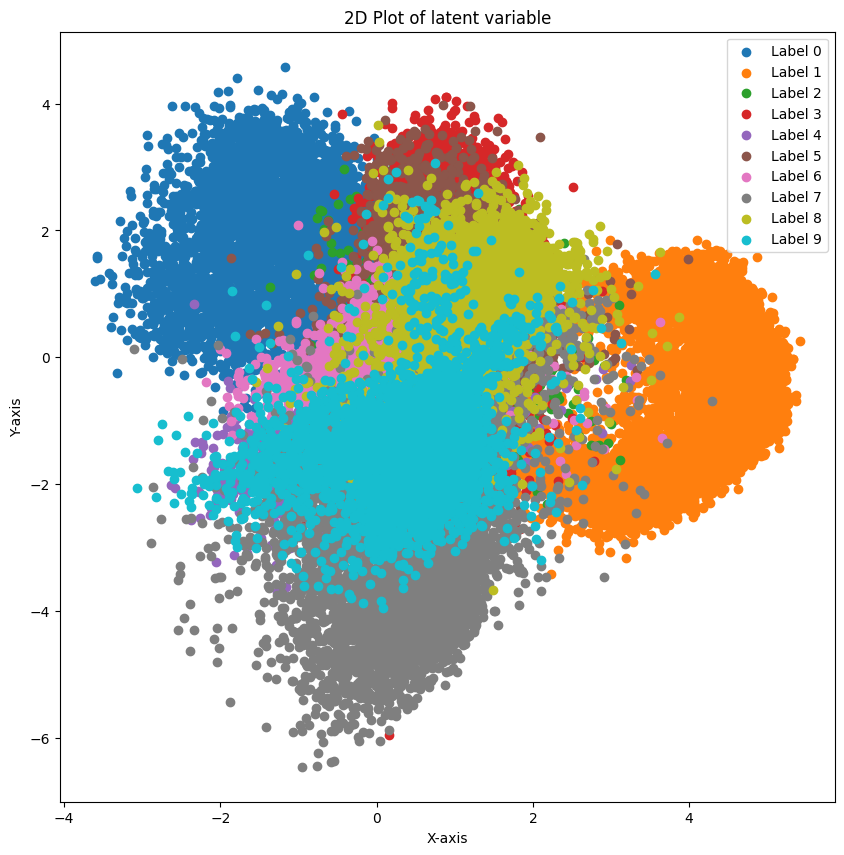

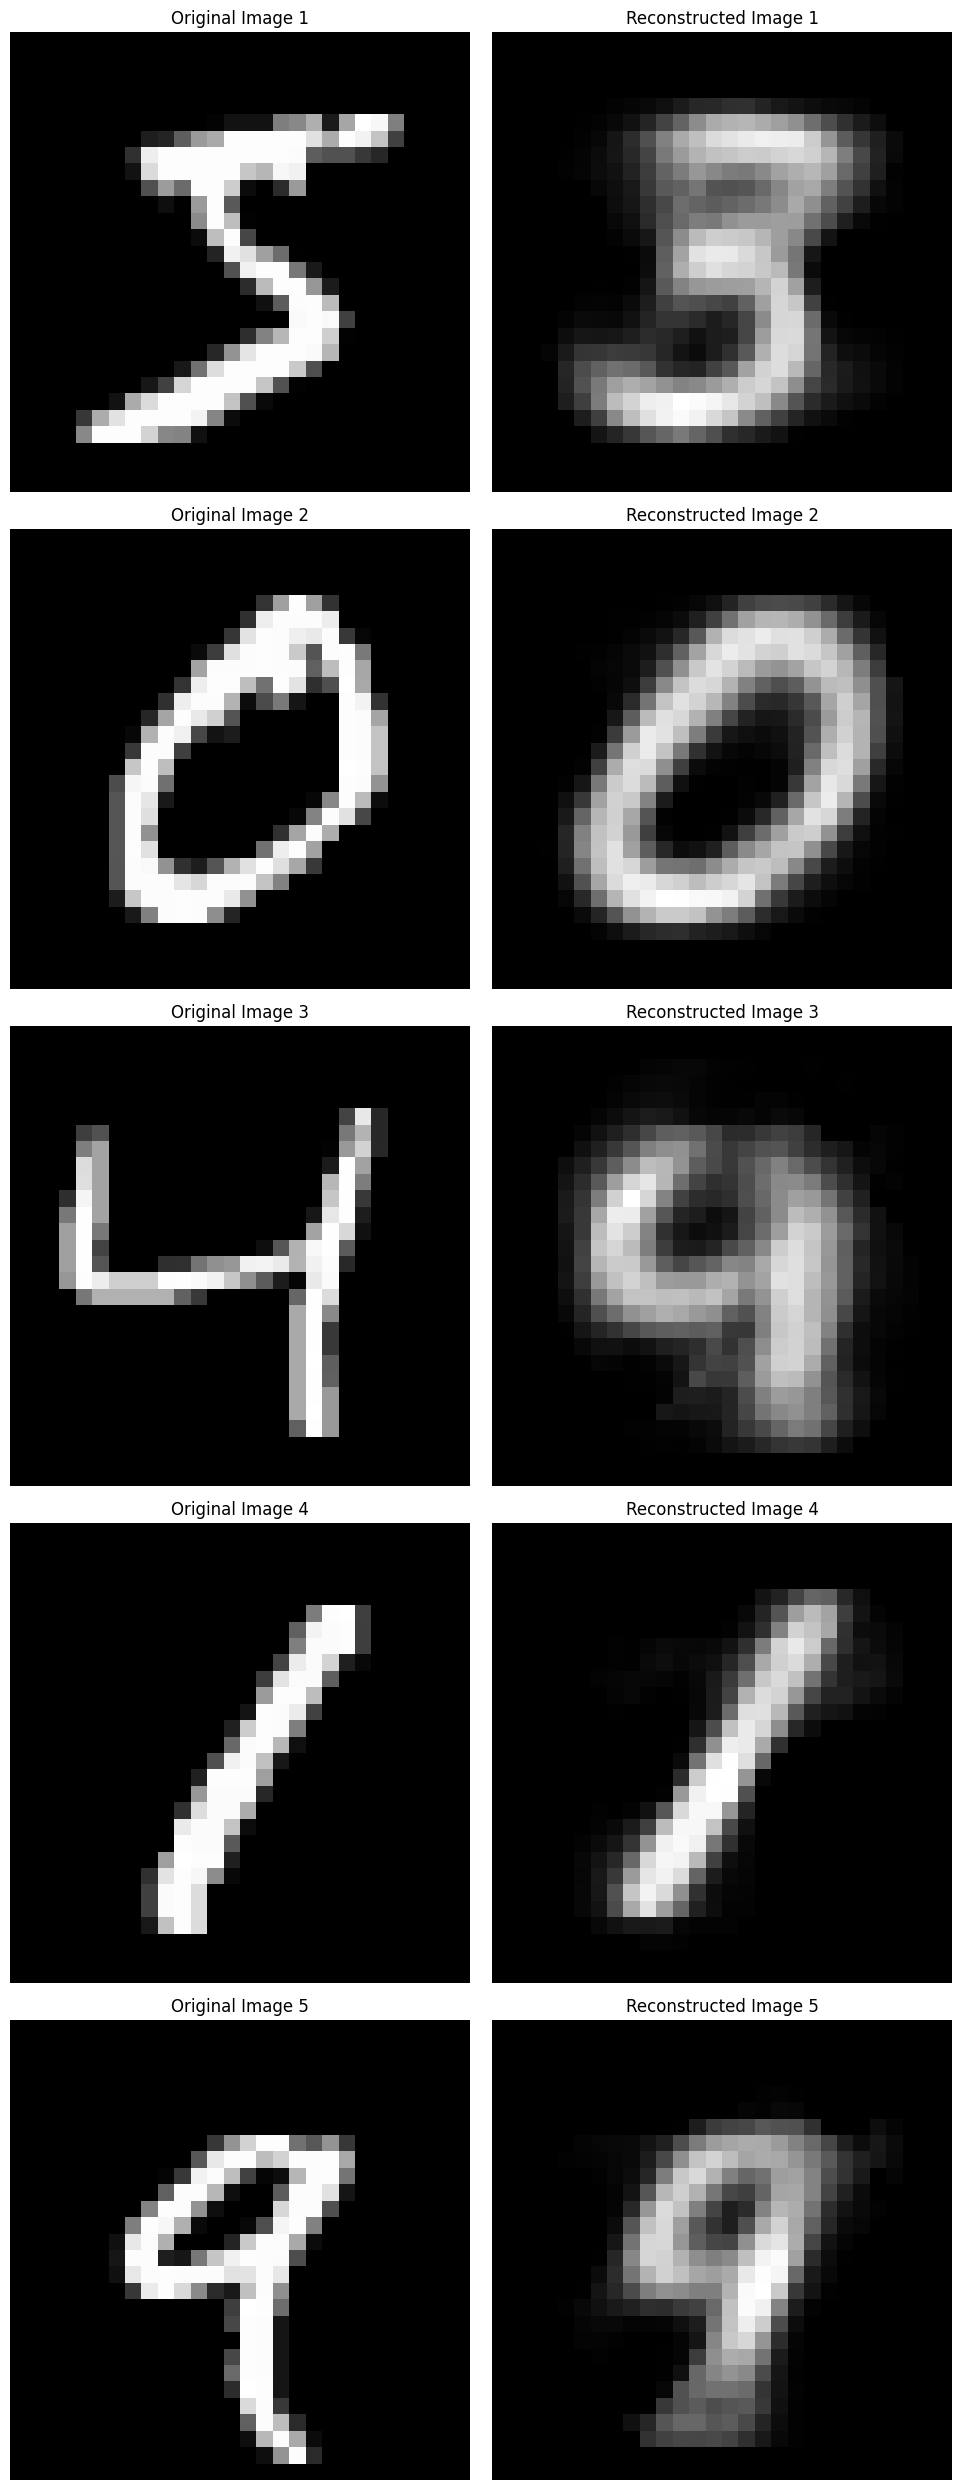

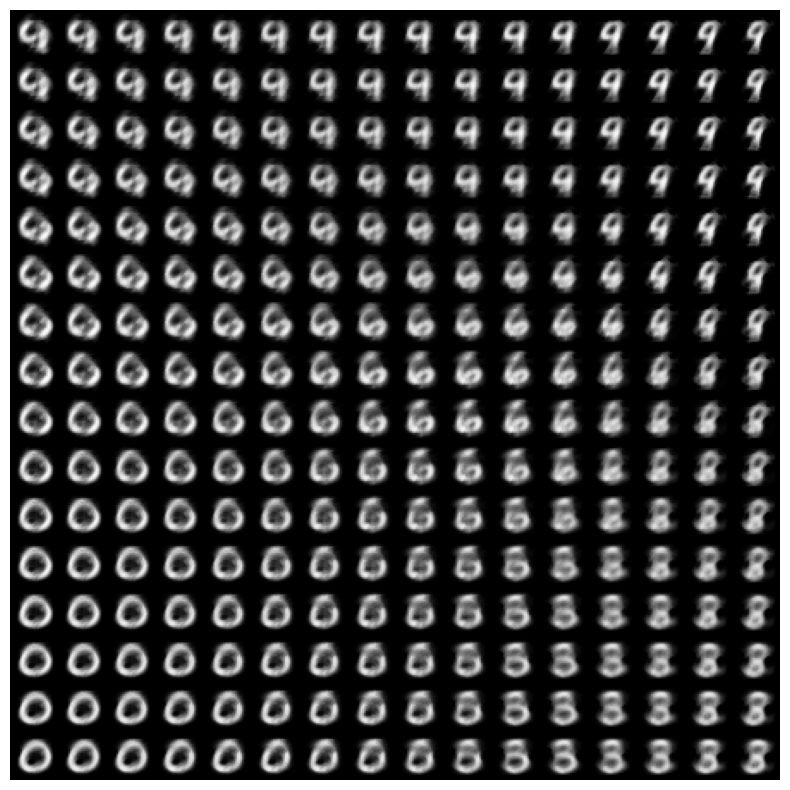

In [ ]:
plot_z(MNIST_loader, vae)
eval(vae)
plot_latent_images(vae, n=16)


 VAE loss with only reconstruction loss (no KL divergence)

In [ ]:
import torch

mse = torch.nn.MSELoss()

def loss_VAE(model, x):
    """
    Compute the VAE loss with only reconstruction loss (no KL divergence).
    """
    output = model(x)

    # Extract components
    reconstructed = output["imgs"]

    # Reconstruction loss
    reconstruction_loss = mse(reconstructed, x)

    return reconstruction_loss  # Return only the reconstruction loss


In [ ]:
epochs = 50
hidden_dims = [128, 64, 32, 16]

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

vae = VAE(input_dim, hidden_dims).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae = train(MNIST_loader, vae, loss_VAE, optimizer_vae, epochs)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0596
Epoch [2/50], Average Loss: 0.0278
Epoch [3/50], Average Loss: 0.0255
Epoch [4/50], Average Loss: 0.0245
Epoch [5/50], Average Loss: 0.0240
Epoch [6/50], Average Loss: 0.0235
Epoch [7/50], Average Loss: 0.0230
Epoch [8/50], Average Loss: 0.0228
Epoch [9/50], Average Loss: 0.0226
Epoch [10/50], Average Loss: 0.0224
Epoch [11/50], Average Loss: 0.0223
Epoch [12/50], Average Loss: 0.0221
Epoch [13/50], Average Loss: 0.0220
Epoch [14/50], Average Loss: 0.0219
Epoch [15/50], Average Loss: 0.0218
Epoch [16/50], Average Loss: 0.0217
Epoch [17/50], Average Loss: 0.0216
Epoch [18/50], Average Loss: 0.0215
Epoch [19/50], Average Loss: 0.0215
Epoch [20/50], Average Loss: 0.0214
Epoch [21/50], Average Loss: 0.0213
Epoch [22/50], Average Loss: 0.0213
Epoch [23/50], Average Loss: 0.0212
Epoch [24/50], Average Loss: 0.0211
Epoch [25/50], Average Loss: 0.0209
Epoch [26/50], Average Loss: 0.0208
Epoch [27/50], Average Loss: 0.0205
Epoch [28/50], Average Loss: 0.0204
E

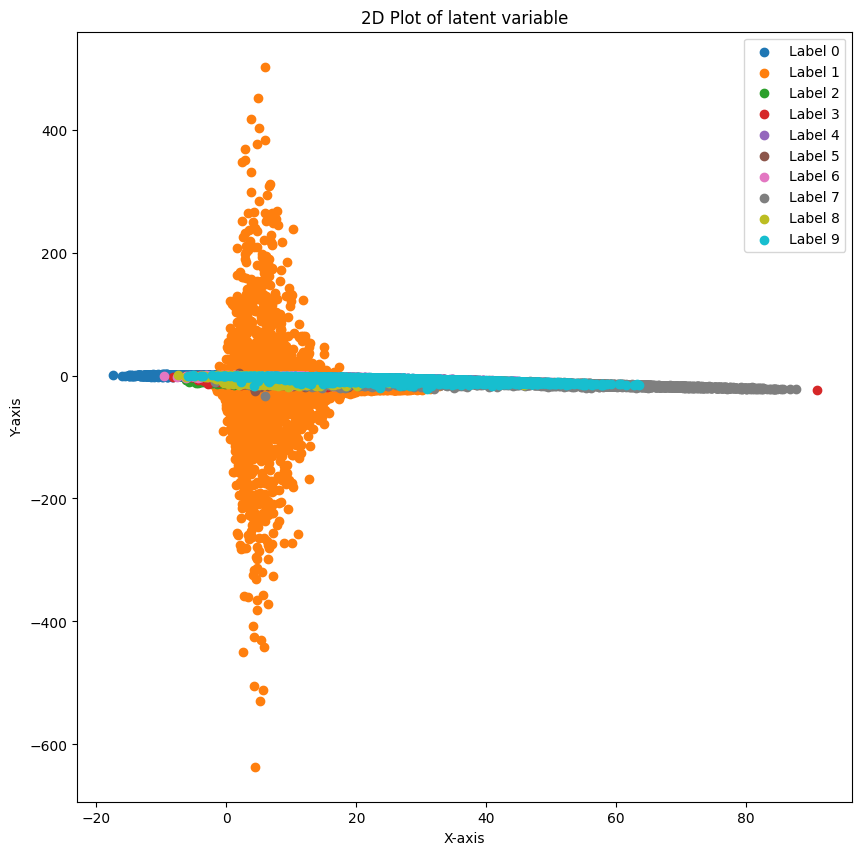

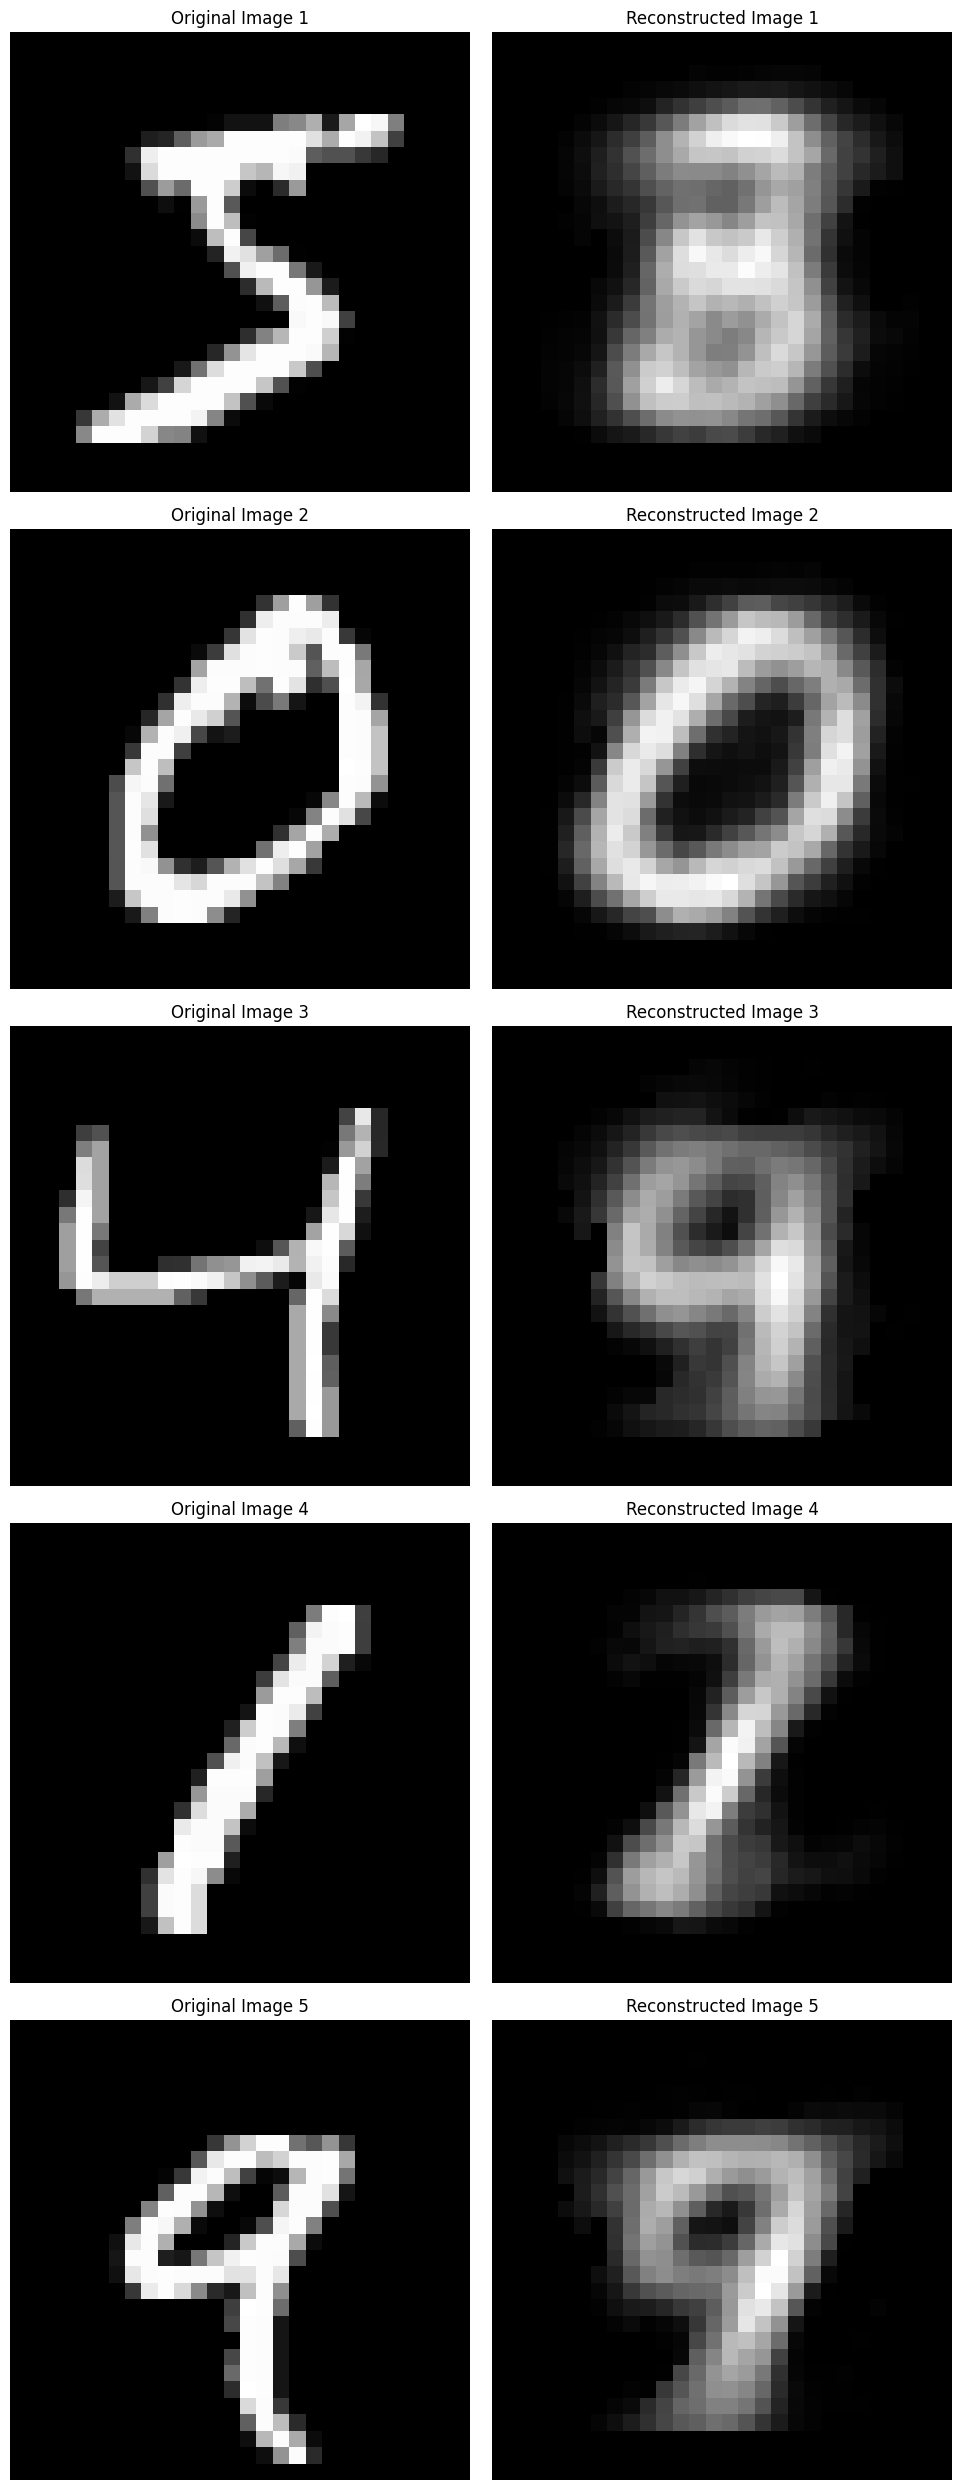

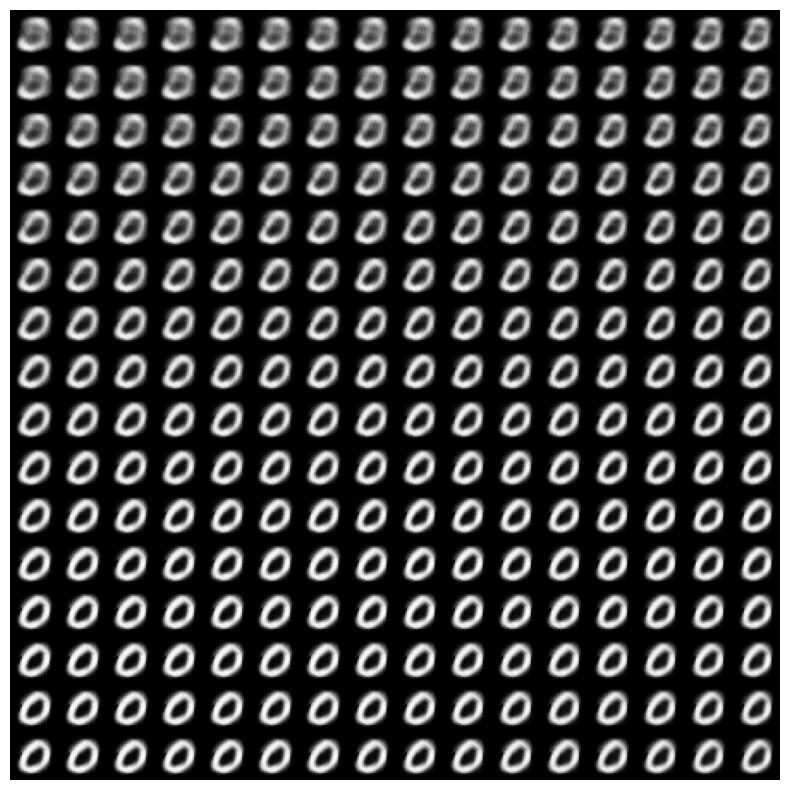

In [ ]:
plot_z(MNIST_loader, vae)
eval(vae)
plot_latent_images(vae, n=16)


 In VAEs, the regularization term is crucial. Conducting a series of experiments adjusting this coefficient

coeff=1e-2

In [ ]:
mse = torch.nn.MSELoss()

def loss_VAE(model, x, coeff=1e-2): #1e-2
    """
    Compute the VAE loss, which includes reconstruction loss and KL divergence.
    """
    output = model(x)

    # Extract components
    reconstructed = output["imgs"]
    mean = output["mean"]
    logvar = output["logvar"]

    # Reconstruction loss
    reconstruction_loss = mse(reconstructed, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)

    # Combined loss
    loss = reconstruction_loss + coeff * kl_loss

    return loss  # Return only the total loss


In [ ]:
epochs = 50
hidden_dims = [128, 64, 32, 16]

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

vae = VAE(input_dim, hidden_dims).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae = train(MNIST_loader, vae, loss_VAE, optimizer_vae, epochs)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0620
Epoch [2/50], Average Loss: 0.0266
Epoch [3/50], Average Loss: 0.0255
Epoch [4/50], Average Loss: 0.0254
Epoch [5/50], Average Loss: 0.0254
Epoch [6/50], Average Loss: 0.0254
Epoch [7/50], Average Loss: 0.0253
Epoch [8/50], Average Loss: 0.0253
Epoch [9/50], Average Loss: 0.0253
Epoch [10/50], Average Loss: 0.0253
Epoch [11/50], Average Loss: 0.0253
Epoch [12/50], Average Loss: 0.0253
Epoch [13/50], Average Loss: 0.0253
Epoch [14/50], Average Loss: 0.0253
Epoch [15/50], Average Loss: 0.0253
Epoch [16/50], Average Loss: 0.0253
Epoch [17/50], Average Loss: 0.0253
Epoch [18/50], Average Loss: 0.0253
Epoch [19/50], Average Loss: 0.0253
Epoch [20/50], Average Loss: 0.0253
Epoch [21/50], Average Loss: 0.0253
Epoch [22/50], Average Loss: 0.0253
Epoch [23/50], Average Loss: 0.0253
Epoch [24/50], Average Loss: 0.0253
Epoch [25/50], Average Loss: 0.0253
Epoch [26/50], Average Loss: 0.0253
Epoch [27/50], Average Loss: 0.0253
Epoch [28/50], Average Loss: 0.0253
E

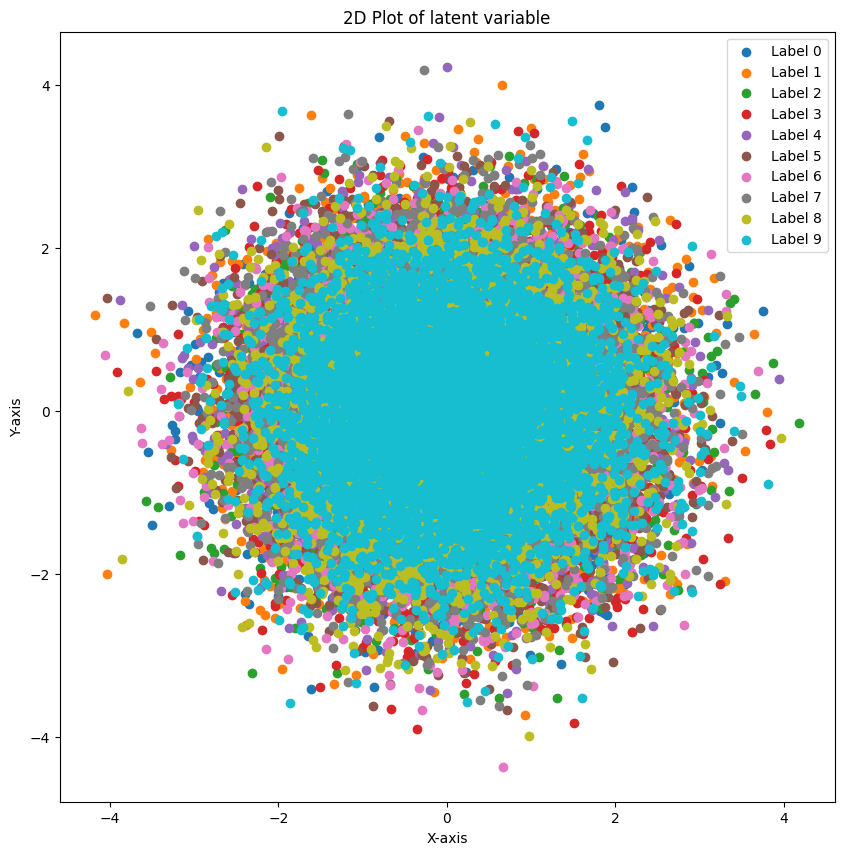

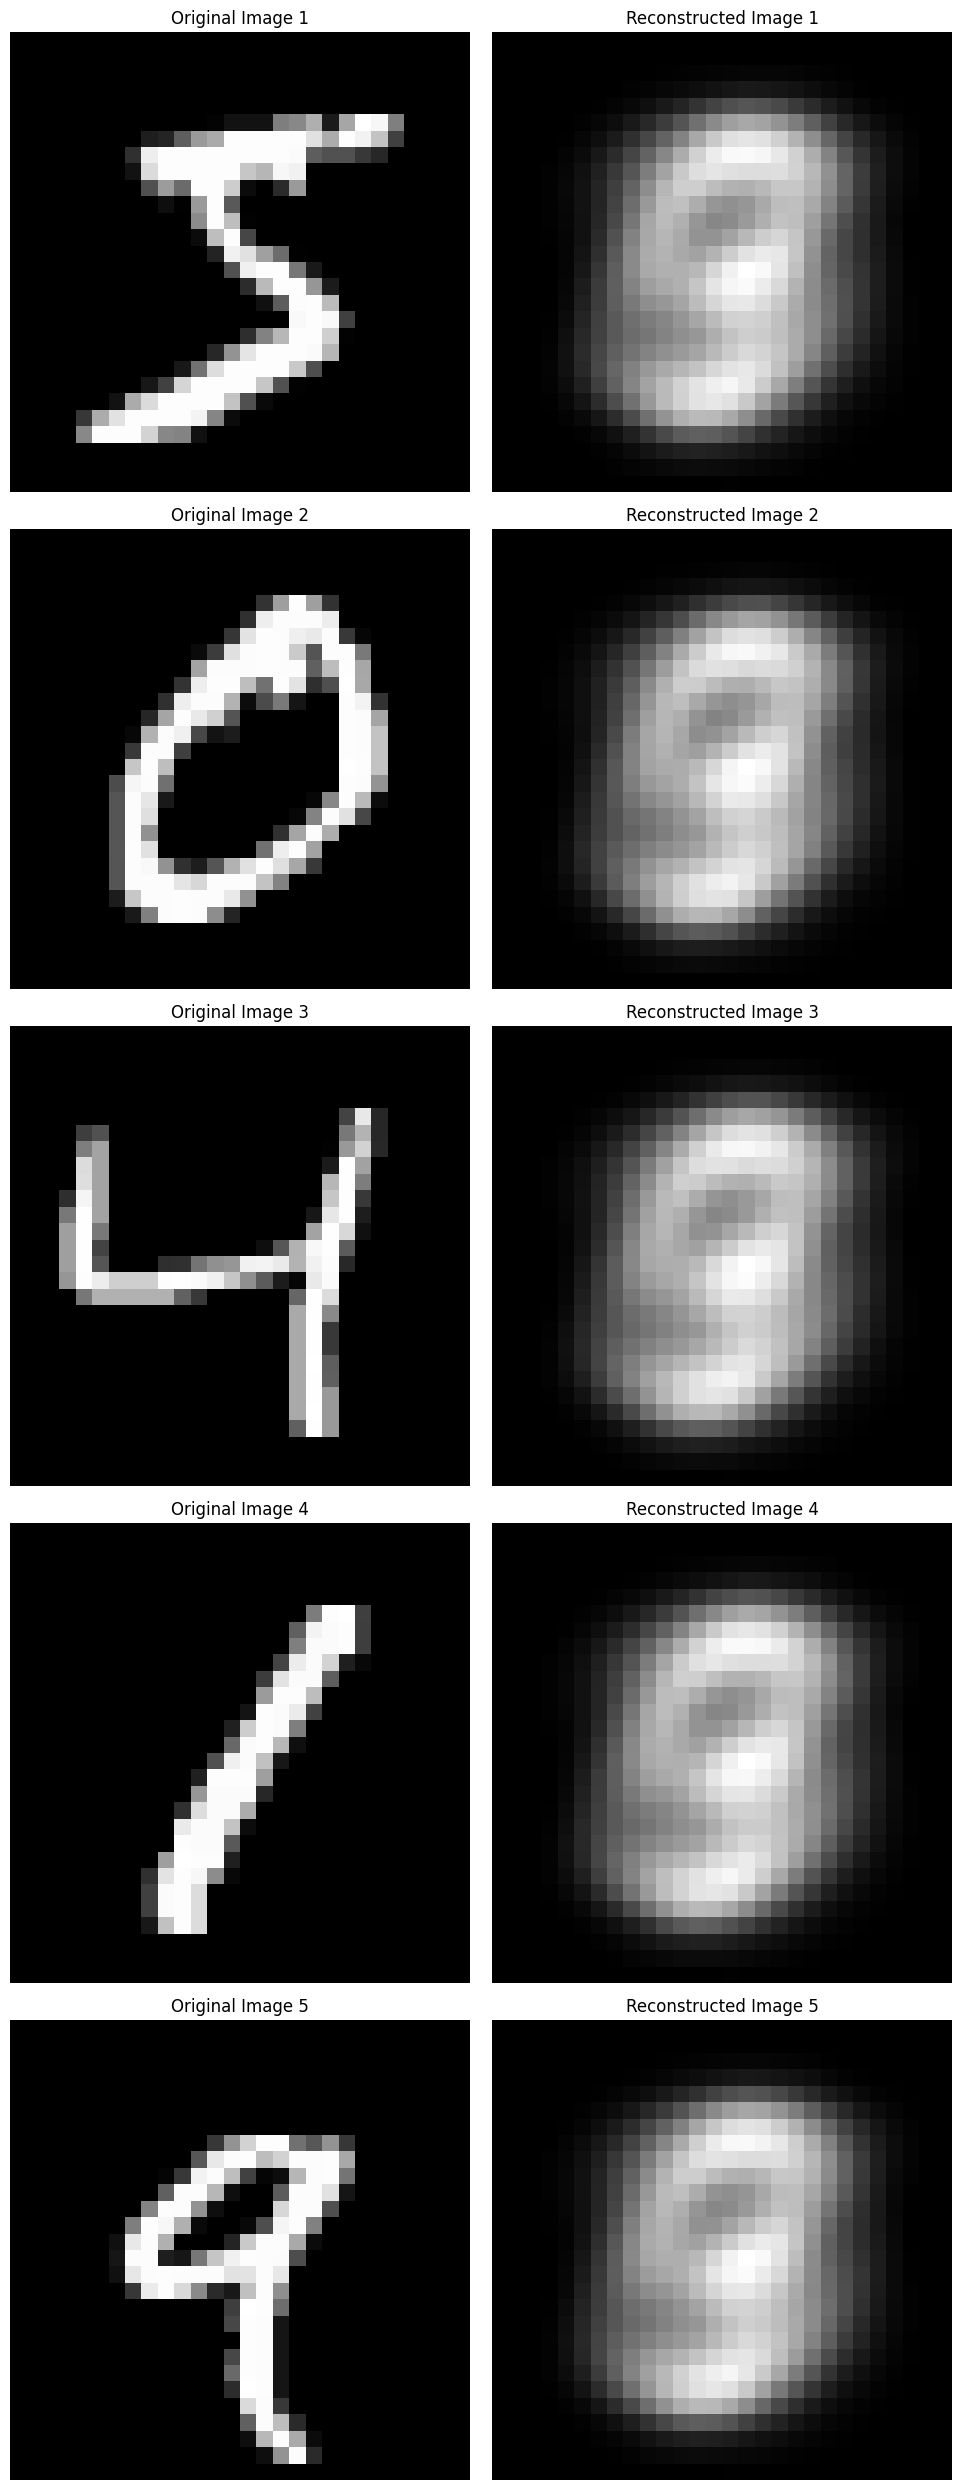

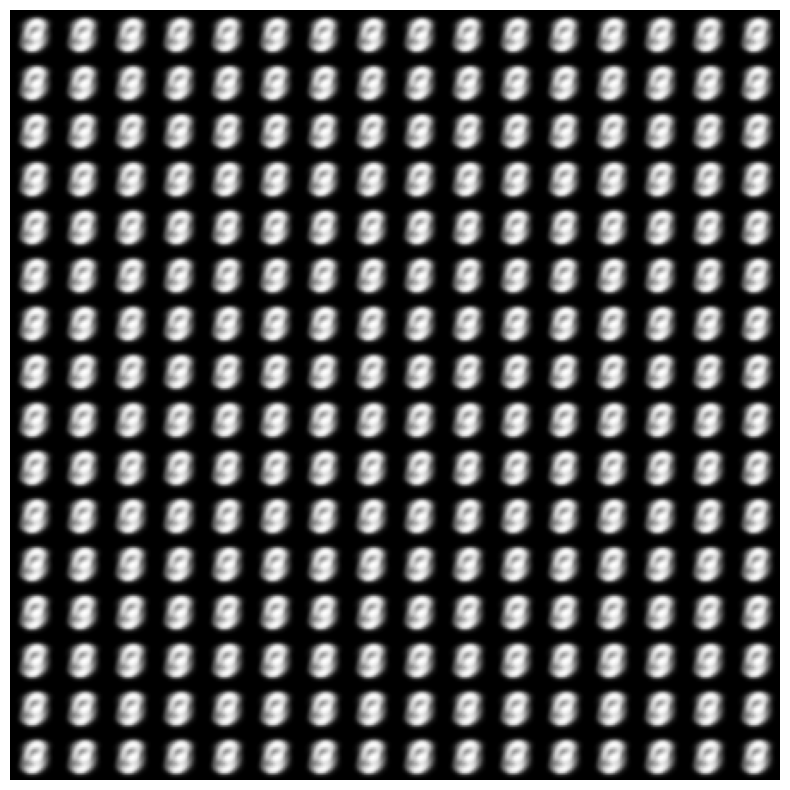

In [ ]:
plot_z(MNIST_loader, vae)
eval(vae)
plot_latent_images(vae, n=16)

coeff=1e-1

In [ ]:
mse = torch.nn.MSELoss()

def loss_VAE(model, x, coeff=1e-1): #1e-1
    """
    Compute the VAE loss, which includes reconstruction loss and KL divergence.
    """
    output = model(x)

    # Extract components
    reconstructed = output["imgs"]
    mean = output["mean"]
    logvar = output["logvar"]

    # Reconstruction loss
    reconstruction_loss = mse(reconstructed, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)

    # Combined loss
    loss = reconstruction_loss + coeff * kl_loss

    return loss  # Return only the total loss


In [ ]:
epochs = 50
hidden_dims = [128, 64, 32, 16]

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

vae = VAE(input_dim, hidden_dims).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae = train(MNIST_loader, vae, loss_VAE, optimizer_vae, epochs)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0613
Epoch [2/50], Average Loss: 0.0263
Epoch [3/50], Average Loss: 0.0256
Epoch [4/50], Average Loss: 0.0255
Epoch [5/50], Average Loss: 0.0254
Epoch [6/50], Average Loss: 0.0254
Epoch [7/50], Average Loss: 0.0254
Epoch [8/50], Average Loss: 0.0253
Epoch [9/50], Average Loss: 0.0253
Epoch [10/50], Average Loss: 0.0253
Epoch [11/50], Average Loss: 0.0253
Epoch [12/50], Average Loss: 0.0253
Epoch [13/50], Average Loss: 0.0253
Epoch [14/50], Average Loss: 0.0253
Epoch [15/50], Average Loss: 0.0253
Epoch [16/50], Average Loss: 0.0253
Epoch [17/50], Average Loss: 0.0253
Epoch [18/50], Average Loss: 0.0253
Epoch [19/50], Average Loss: 0.0253
Epoch [20/50], Average Loss: 0.0253
Epoch [21/50], Average Loss: 0.0253
Epoch [22/50], Average Loss: 0.0253
Epoch [23/50], Average Loss: 0.0253
Epoch [24/50], Average Loss: 0.0253
Epoch [25/50], Average Loss: 0.0253
Epoch [26/50], Average Loss: 0.0253
Epoch [27/50], Average Loss: 0.0253
Epoch [28/50], Average Loss: 0.0253
E

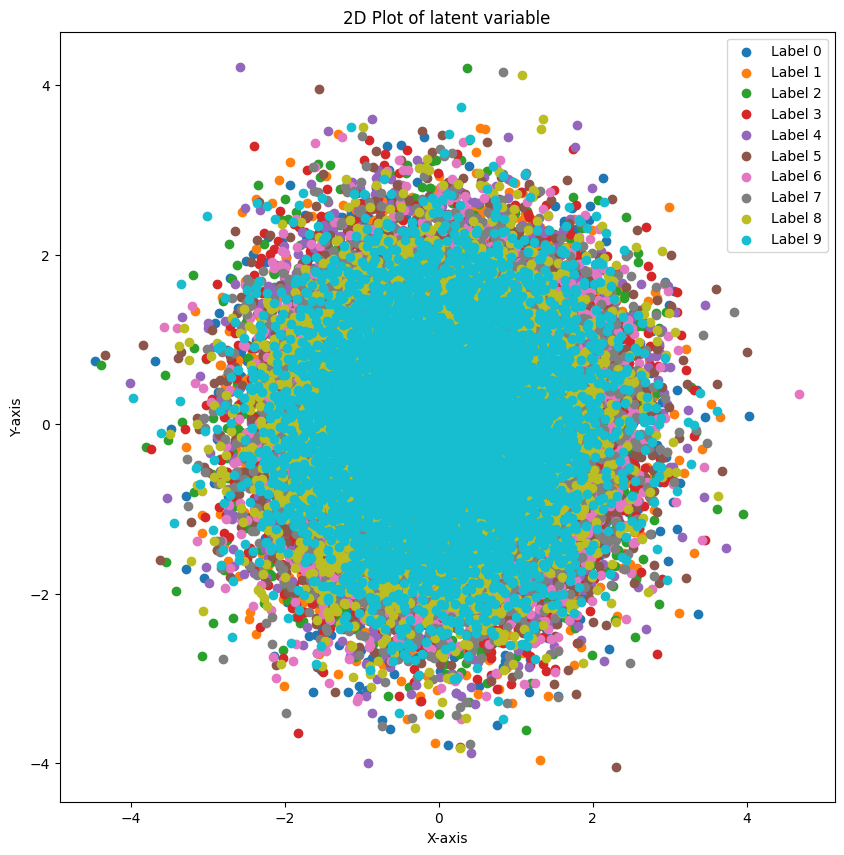

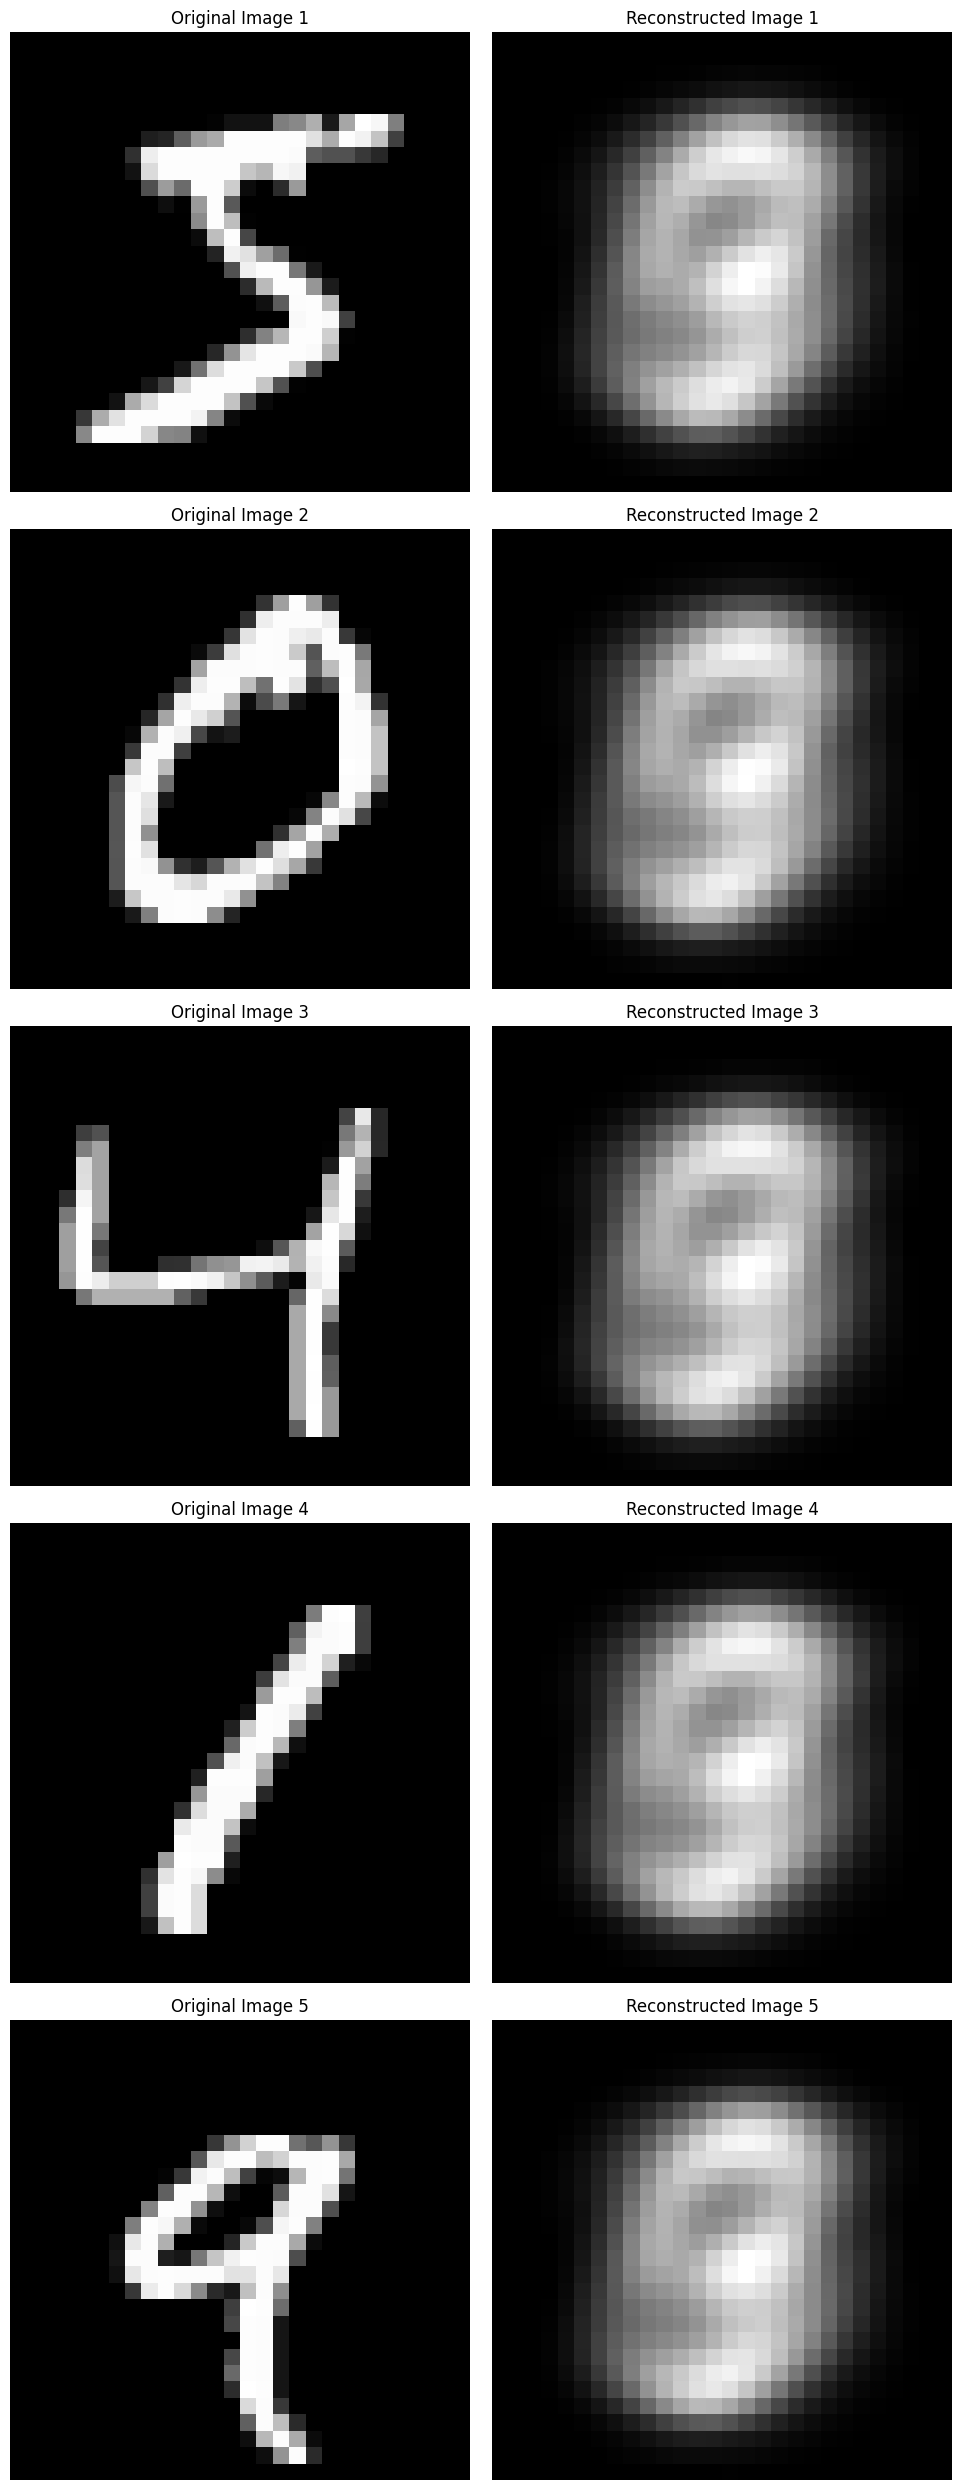

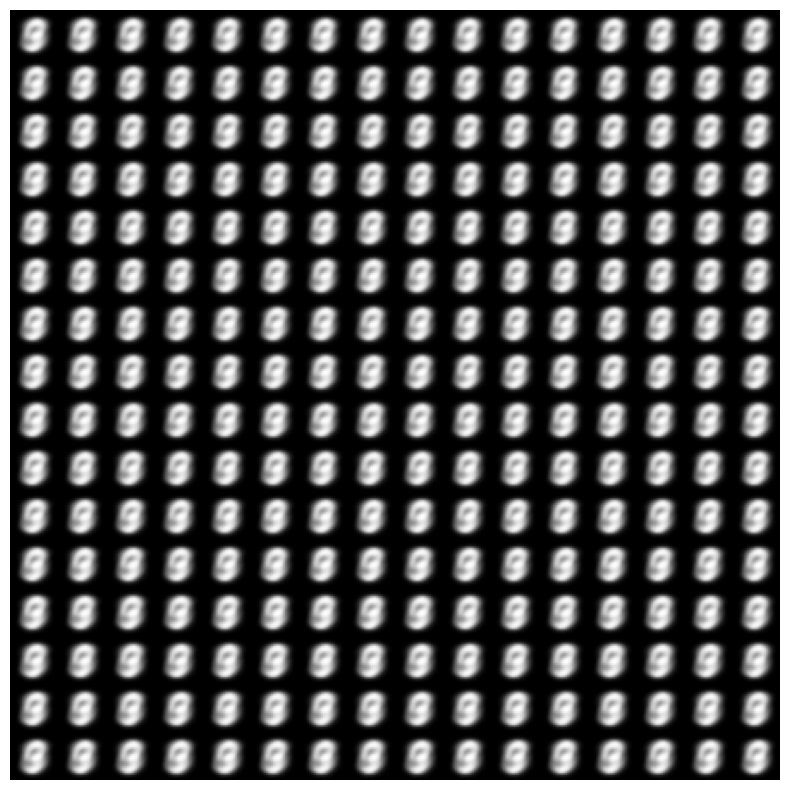

In [ ]:
plot_z(MNIST_loader, vae)
eval(vae)
plot_latent_images(vae, n=16)

## **Questions**
1. [5 pts] In VAEs, remove the KL loss and keep the reconstruction loss only, train the model. Do you observe the std from encoder moves to 0 as we discussed in the class?

**Ans:** Without the KL loss, a VAE behaves like a standard autoencoder, focusing solely on minimizing reconstruction error. This causes the encoder's standard deviation to shrink toward zero, collapsing the latent space into deterministic points. As a result, the model loses its generative capabilities and struggles to produce diverse or meaningful samples. The KL loss regularizes the latent space, preventing this collapse by enforcing a smooth, continuous distribution.




2. [10 pts] In VAEs, the regularization term is crucial. Conduct a series of experiments where you adjust this coefficient and observe its impact on reconstruction quality and latent space distribution.

**Observation**:For small KL coefficients (near zero), the model behaves more like a standard autoencoder, where the latent space distribution becomes highly clustered or poorly structured. In this case, the model focuses more on accurate reconstruction, with less concern for maintaining a well-formed latent space.

As the KL coefficient increases, the model enforces q(z∣x)≈N(0,I) more strictly. This results in a more spread-out or well-clustered latent distribution. However, the reconstructions may become blurrier or less accurate since the model prioritizes aligning with the prior rather than perfectly memorizing each sample.
There is typically a middle ground where we achieve a balance between good reconstruction quality and a smooth, structured latent space.
In a Variational Autoencoder (VAE), the goal is to reconstruct well while keeping the encoder distribution close to a unit Gaussian. A higher KL weight imposes a stronger penalty for deviating from the prior, leading to a more dispersed latent space but less accurate reconstructions, as the model loses flexibility in shifting latent codes. Conversely, a lower KL weight reduces the pressure to conform to the prior, resulting in better reconstructions but a potentially collapsed or unstructured latent space.



3. [5 pts] After your implementations and experiments, are the generated images from VAE really smoother than from AE? Why?


**Ans:** Yes, the images generated by a Variational Autoencoder (VAE) are smoother than those from a standard Autoencoder (AE). This is because VAEs use a probabilistic approach, encoding data as distributions rather than fixed points, which ensures smoother transitions in the latent space.
Since VAE’s are learning the data distribution, we are likely to see continuous changes in output images rather than abrupt changes.
The VAE is trying to model p(x) in a probabilistic sense, learning a latent distribution q(z∣x). When we sample from the prior and decode, we’re generating from a learned distribution, leading to smoother transitions among images.
The AE simply tries to minimize reconstruction error and is deterministic. VAEs must handle random sampling. That typically leads to reconstructions (and newly generated images) that are a bit blurrier or smoother, because the model must account for the variety in each pixel distribution, rather than memorizing every fine detail.
AEs can overfit local pixel details more easily (especially if they have enough capacity), leading to sharper but less generalizable or smooth generative behavior.
